## Topic Diversification
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.jupyter.org/github/david-cortes/datascienceprojects/blob/master/machine_learning/topic_diversification.ipynb)*

This project consists of taking a recommendation list (can be applied to anything, in this case it’s movies) that is sorted by a score produced by some recommendation formula, containing more elements than the final recommendation list that will be shown to the user, and selecting a subset of those elements that contains more diversity than the original top-N elements.

The objective is to make the list more diverse in the sense of containing elements that are not all too similar to each other. As recommendation formulas tend to be based on estimating the rating that a user would give to an item or the probability that he/she would click or buy it, these lists can end up containing elements that are all too similar – e.g. only books from the same author, only movies from a certain genre, etc. – and, despite having good predictive accuracy, might not be as valuable to the user as lists of recommendations that cater to more different interests.

There are different ways of making a list more diverse, and all of these require some information about the elements included, such as the genres of a movie or the tags that they have received. Here I’ll use movies' genres and PCA-reduced tags assigned by users. The data is taken from the [MovieLens latest dataset](https://grouplens.org/datasets/movielens/latest/) (at the time this was produced, the last update was on 10/2016), which includes 24M movie ratings from 260K users to 40K movies, the movies genres, and 1,128 possible tags applied to most of those movies, in a numerical scale as explained in [Vig, J., Sen, S., & Riedl, J. (2012). The tag genome: Encoding community knowledge to support novel interaction. ACM Transactions on Interactive Intelligent Systems (TiiS), 2(3), 13.](http://dl.acm.org/citation.cfm?id=2362395).

I’ll make a simple recommendation list by taking the average rating that a movie has received, multiplied by the number of users who have rated it, and sorting by this score. The final recommendation will be limited to 10 movies, and the candidate pool from which to diversify will be limited to the top 50 movies by this score.
** *
## Sections

[1. Producing the recommendation list](#p1)

[2. Diversification as Maximum Coverage Problem](#p2)

[3. Diversification as Maximal Marginal Relevance](#p3)

[4. Topic Diversifcation heuristic](#p4)

<a id="p1"></a>
## 1. Producing the recommendation list

This is a generic non-personalized recommendation list, accordignto the movies' average rating and people who have rated them, as explained at the beginning:

In [1]:
import pandas as pd, numpy as np
import warnings

warnings.filterwarnings('ignore')

ratings=pd.read_csv('D:\\Downloads\\movielens\\ml-latest\\ml-latest\\ratings.csv')
movies=pd.read_csv('D:\\Downloads\\movielens\\ml-latest\\ml-latest\\movies.csv')

top_rated=(ratings.assign(raters=ratings.rating>=0).groupby('movieId').agg({'rating':np.mean,'raters':np.sum})
           .assign(score=lambda x: x.rating*x.raters).sort_values('score',ascending=False).head(50))
movies=movies.loc[movies.movieId.map(lambda x: x in top_rated.index)]
del ratings
top_rated.join(movies.set_index('movieId')).head(10)

,rating,raters,score,title,genres
movieId,,,,,
318,4.433089,84455.0,374396.5,"Shawshank Redemption, The (1994)",Crime|Drama
356,4.047109,86629.0,350597.0,Forrest Gump (1994),Comedy|Drama|Romance|War
296,4.163386,83523.0,347738.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
593,4.153854,80274.0,333446.5,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
260,4.142865,72215.0,299177.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2571,4.160476,71450.0,297266.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller
527,4.275963,63889.0,273187.0,Schindler's List (1993),Drama|War
480,3.656063,72147.0,263774.0,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
110,4.022716,63920.0,257132.0,Braveheart (1995),Action|Drama|War


<a id="p2"></a>
## 2. Diversification as Maximum Coverage Problem

One of the simplest ways to diversify the recommendation list is by making them cover the largest possible set of genres, plus some penalization for the drop in score that this diversification would produce. This would of course tend to favor movies with more genres (as each movie can belong to more than 1 genre).

Such a process can be modeled in a similar way to the [maximum coverage problem](https://en.wikipedia.org/wiki/Maximum_coverage_problem), by adding to the maximization objective a term dependent on the scaled movie score, such as this:

$$ \sum_{g \in genres} Genre_g + \sum_{m \in TopMovies} Score_m \times Movie_m $$
$$ s.t. $$
$$ \sum_{m \in TopMovies} Movie_m = \left\vert Final\, Recommended\, List \right\vert $$
$$ \sum_{m \in g} Movie_m >= Genre_g \,\, \forall g \in genres $$
$$ Movie_m, Genre_g \in \{0,1\} \,\, \forall m \in TopMovies, g \in genres $$


(Where $Movie_m$ and $Genre_g$ are the decision variables determining whehter a particular movie ends up in the final recommendation list and whether this list contains each genre).


While solving this problem is NP-hard, branch-and-cut algorithms for mixed-integer programming can solve it very quickly if the recommendation list is short. In this case, I'll use Google's or-tools for modeling the problem, and solve it using coin-or's CBC - both of these are free software:

In [2]:
# adding genres and rescaling year
import re

movies['hasYear']=movies.title.map(lambda x: bool(re.search("\s\((\d{4})\)$",x.strip())))
movies['Year']='unknown'
movies['Year'].loc[movies.hasYear]=movies.title.loc[movies.hasYear].map(lambda x: re.search("\s\((\d{4})\)$",x.strip()).group(1))
del movies['hasYear']

movies['genres']=movies.genres.map(lambda x: set(x.split('|')))
present_genres=set()
for movie in movies.itertuples():
    present_genres=present_genres.union(movie.genres)
for genre in present_genres:
    movies['genre'+genre]=movies.genres.map(lambda x: 1.0*(genre in x))
    
# switching movieId to a column in the top ratings df
top_rated=top_rated.reset_index()

# adding a movie's genres to the top rated df
top_rated=pd.merge(top_rated,movies[['movieId','title','genres']],on='movieId')

Creating the decision variables:

In [3]:
from ortools.linear_solver import pywraplp

# starting solver
solver = pywraplp.Solver('diversify_list',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# converting movie IDs to sequential integers
movie_to_int=dict()
int_to_movie=dict()
cnt=0
for movie in movies.movieId:
    movie_to_int[movie]=cnt
    int_to_movie[cnt]=movie
    cnt+=1
    
# variables indicating which movie is included in the final recommendation list
rec_movie=[solver.BoolVar('movie'+str(m)) for m in range(cnt)]

# assigning integer IDs to genres
genre_to_int=dict()
cnt=0
for genre in present_genres:
    genre_to_int[genre]=cnt
    cnt+=1

# variables indicating the present genres
genres=[solver.BoolVar('genre'+str(g)) for g in range(cnt)]

Modeling the problem in or-tools:

In [4]:
# maximize the number of included genres plus the score that the included movies bring
solver.Maximize(solver.Sum(genres) + solver.Sum((m.score/300000)*rec_movie[movie_to_int[m.movieId]] for m in top_rated.itertuples()))

# only 10 movies are selected
solver.Add(solver.Sum(rec_movie)==10)

# genres are only selected when a recommended movie has that genre
for genre in present_genres:
    solver.Add(solver.Sum(rec_movie[movie_to_int[m.movieId]] for m in top_rated.itertuples() if (genre in m.genres))>=genres[genre_to_int[genre]])

Timing the solver:

In [5]:
%%time
solver.Solve()

Wall time: 35 ms


0

Checking how the recommendation list was altered:

In [6]:
final_recs=set()
for m in range(len(rec_movie)):
    if rec_movie[m].solution_value()>.5:
        final_recs.add(int_to_movie[m])
        
recs_maxcover=list(top_rated.title.loc[top_rated.movieId.map(lambda x: x in final_recs)])
new_list=top_rated.loc[top_rated.movieId.map(lambda x: x in final_recs)]
new_list['previously_here']=list(top_rated.head(10).title)
new_list

,movieId,rating,raters,score,title,genres,previously_here
0,318,4.433089,84455.0,374396.5,"Shawshank Redemption, The (1994)","{Drama, Crime}","Shawshank Redemption, The (1994)"
1,356,4.047109,86629.0,350597.0,Forrest Gump (1994),"{Drama, Comedy, War, Romance}",Forrest Gump (1994)
2,296,4.163386,83523.0,347738.5,Pulp Fiction (1994),"{Drama, Comedy, Crime, Thriller}",Pulp Fiction (1994)
3,593,4.153854,80274.0,333446.5,"Silence of the Lambs, The (1991)","{Thriller, Crime, Horror}","Silence of the Lambs, The (1991)"
4,260,4.142865,72215.0,299177.0,Star Wars: Episode IV - A New Hope (1977),"{Action, Sci-Fi, Adventure}",Star Wars: Episode IV - A New Hope (1977)
5,2571,4.160476,71450.0,297266.0,"Matrix, The (1999)","{Action, Sci-Fi, Thriller}","Matrix, The (1999)"
6,527,4.275963,63889.0,273187.0,Schindler's List (1993),"{Drama, War}",Schindler's List (1993)
10,50,4.308636,56348.0,242783.0,"Usual Suspects, The (1995)","{Thriller, Crime, Mystery}",Jurassic Park (1993)
28,590,3.741088,50803.0,190058.5,Dances with Wolves (1990),"{Drama, Adventure, Western}",Braveheart (1995)
44,595,3.674512,40195.0,147697.0,Beauty and the Beast (1991),"{Musical, IMAX, Animation, Children, Romance, ...",Toy Story (1995)


<a id="p3"></a>
## 3. Diversification as Maximal Marginal Relevance

Given a function that determines the similarity between two elements in the recommended list, it's possible to reorder them using the maximal marginal relevance heuristic, as described in [Carbonell, J., & Goldstein, J. (1998, August). The use of MMR, diversity-based reranking for reordering documents and producing summaries. In Proceedings of the 21st annual international ACM SIGIR conference on Research and development in information retrieval (pp. 335-336). ACM.](http://repository.cmu.edu/cgi/viewcontent.cgi?article=1330&context=compsci).

Intuitively, this aims to rerank the list in such a way that each next element in the list gets a penalty according to it's maximal similarity to any element ranked above it. This method was originally thought for the case of search result rankings, where there is a function determining the relevance of a document in regards to a query, but here the list is fixed, thus this relevance score is the same as the score they get in the list.

In order to get the pairwise similarities between two movies, I'll take their genres, year of production and tags. As there are too many tags and I won't want them to weight too much in the formula, I'll first recude their dimensionality by taking their first principal components. The pairwise similarity will then be calculated as the cosine distance of such features (vectors of movie's one-hot encoded genres, scaled year of production and some principal components of tags).

In [7]:
# rescaling the year in order to give it more weight:
def scaled_year(x):
    if x=='unknown':
        return 1
    else:
        x=int(x)
        return (x-1990)/4

movies['ScaledYear']=movies.Year.map(scaled_year)

Converting the tags to their principal components:

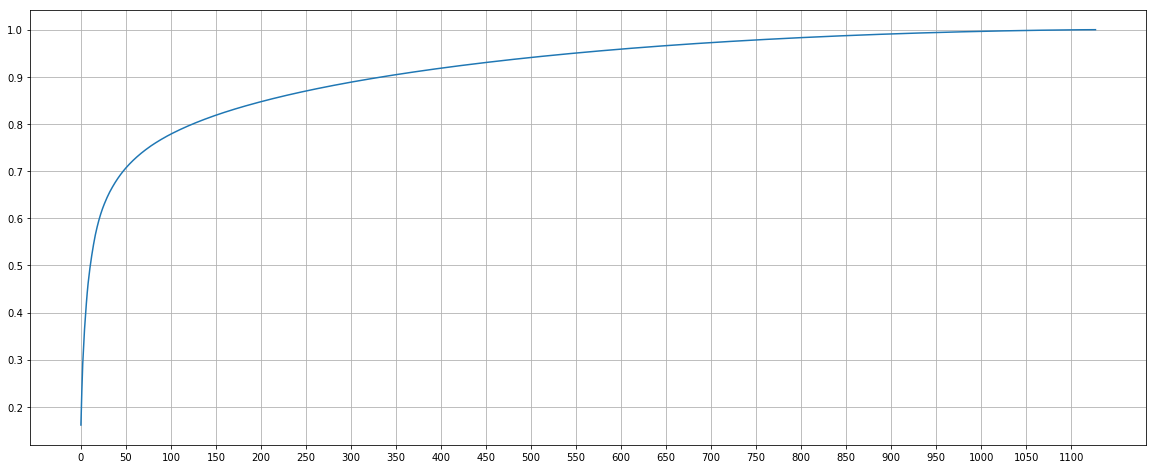

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

tags=pd.read_csv('D:\\Downloads\\movielens\\ml-latest\\ml-latest\\genome-scores.csv')
tags_wide=tags.pivot(index='movieId', columns='tagId', values='relevance')
tags_wide=tags_wide.fillna(0)
pca=PCA(svd_solver='full')
pca.fit(tags_wide)

plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0.2, 1.1, .1))
plt.xticks(np.arange(0, 1128, 50))
plt.grid()

From the plot above, using the first 50 principal components seems to carry most of the information contained by the tags, so I'll take these only:

In [9]:
tags_pca=pd.DataFrame(pca.transform(tags_wide)[:,:50]/3)
tags_pca.columns=["pc"+str(x) for x in tags_pca.columns.values]
tags_pca['movieId']=tags_wide.index
del tags
del tags_wide
movies=pd.merge(movies,tags_pca,how='inner',on='movieId')
movies_features=movies.copy()
del movies_features['title']
del movies_features['genres']
del movies_features['Year']
movies_features.set_index('movieId',inplace=True)
movies_features.head()

,genreComedy,genreDrama,genreMystery,genreIMAX,genreAdventure,genreChildren,genreCrime,genreHorror,genreWestern,genreMusical,...,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.053180,0.074886,-0.100750,0.049117,-0.008817,-0.002725,-0.016538,-0.065847,-0.014171,-0.083305
32,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.048473,-0.003494,-0.120764,-0.173214,-0.001152,-0.191789,0.089015,0.078067,-0.052995,0.021039
47,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.073253,0.008341,-0.125062,0.115022,0.044525,-0.103325,0.020353,-0.100851,-0.023210,-0.001501
50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.107380,0.042832,-0.065706,-0.046828,-0.004257,-0.245711,-0.012025,0.020237,-0.115989,0.088346
110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039152,-0.020539,-0.216745,0.049616,-0.054584,-0.147981,0.076041,0.011075,0.044595,0.048206


Constructing the similarity function;

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def sim_movies(movie1,movie2):
    vec1=movies_features.loc[movie1].reshape(1,-1)
    vec2=movies_features.loc[movie2].reshape(1,-1)
    return cosine_similarity(vec1,vec2)

Implementing the heuristic and checking the results - Here I'll set the diversification factor at 0.3, meaning that the final list is more geared towards diversified elements than original scores:

In [11]:
rec_mmr=[top_rated.movieId.iloc[0]]
l=.3

for i in range(9):
    movies_left=top_rated.loc[top_rated.movieId.map(lambda x: x not in rec_mmr)]
    movies_orig_score=l*movies_left.score/300000
    movies_adj_score=np.array([np.max([sim_movies(m1,m2) for m2 in rec_mmr]) for m1 in movies_left.movieId])
    movies_new_score=movies_orig_score-(1-l)*movies_adj_score
    rec_mmr.append(movies_left.movieId.iloc[np.argmax(movies_new_score)])
    
new_list=top_rated.loc[top_rated.movieId.map(lambda x: x in rec_mmr)]
new_list['reorder_maxcover']=recs_maxcover
new_list['originally_here']=list(top_rated.head(10).title)
new_list

,movieId,rating,raters,score,title,genres,reorder_maxcover,originally_here
0,318,4.433089,84455.0,374396.5,"Shawshank Redemption, The (1994)","{Drama, Crime}","Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)"
5,2571,4.160476,71450.0,297266.0,"Matrix, The (1999)","{Action, Sci-Fi, Thriller}",Forrest Gump (1994),Forrest Gump (1994)
6,527,4.275963,63889.0,273187.0,Schindler's List (1993),"{Drama, War}",Pulp Fiction (1994),Pulp Fiction (1994)
7,480,3.656063,72147.0,263774.0,Jurassic Park (1993),"{Action, Sci-Fi, Adventure, Thriller}","Silence of the Lambs, The (1991)","Silence of the Lambs, The (1991)"
19,150,3.883285,56077.0,217763.0,Apollo 13 (1995),"{Drama, Adventure, IMAX}",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode IV - A New Hope (1977)
20,4993,4.109445,51871.0,213161.0,"Lord of the Rings: The Fellowship of the Ring,...","{Fantasy, Adventure}","Matrix, The (1999)","Matrix, The (1999)"
21,608,4.105454,50463.0,207173.5,Fargo (1996),"{Drama, Comedy, Crime, Thriller}",Schindler's List (1993),Schindler's List (1993)
22,1270,3.913528,52219.0,204360.5,Back to the Future (1985),"{Comedy, Sci-Fi, Adventure}","Usual Suspects, The (1995)",Jurassic Park (1993)
23,47,4.063859,50142.0,203770.0,Seven (a.k.a. Se7en) (1995),"{Thriller, Mystery}",Dances with Wolves (1990),Braveheart (1995)
44,595,3.674512,40195.0,147697.0,Beauty and the Beast (1991),"{Musical, IMAX, Animation, Children, Romance, ...",Beauty and the Beast (1991),Toy Story (1995)


<a id="p4"></a>
## 4. Topic Diversifcation heuristic

Another this is another heuristic based on [Ziegler, C. N., McNee, S. M., Konstan, J. A., & Lausen, G. (2005, May). Improving recommendation lists through topic diversification. In Proceedings of the 14th international conference on World Wide Web (pp. 22-32). ACM.](https://www.researchgate.net/profile/Cai-Nicolas_Ziegler/publication/200110416_Improving_recommendation_lists_through_topic_diversification/links/0fcfd510f5bfa4aa48000000.pdf) (written by some of the same people who develop and mantain the GroupLens datasets, including the MovieLens data used here).

The idea is to rerank elements according to the rank that they would get when ordering them by the recommendation formula's score, and when ordering them inversely according to their sum of similarity to the elements ranked above. Just like the Maximal Marginal Relevance heuristic, this is based on element's pairwise similarities, which I'll take in the same way as before.

Again, I'll set the diversification factor at 0.3, making the final list is more geared towards diversified elements than original scores:

In [12]:
rec_td=[top_rated.movieId.iloc[0]]
theta=.3

for i in range(9):
    movies_left=top_rated.loc[top_rated.movieId.map(lambda x: x not in rec_td)]
    movies_orig_rank=movies_left.index
    movies_dissim_rank=np.argsort([np.sum([sim_movies(m1,m2) for m2 in rec_td]) for m1 in movies_left.movieId])
    rec_td.append(movies_left.movieId.iloc[np.argmin(np.array(theta*movies_orig_rank+(1-theta)*movies_dissim_rank))])
    
new_list=top_rated.loc[top_rated.movieId.map(lambda x: x in rec_td)]
new_list['reorder_mmr']=list(top_rated.title.loc[top_rated.movieId.map(lambda x: x in rec_mmr)])
new_list['reorder_maxcover']=recs_maxcover
new_list['originally_here']=list(top_rated.head(10).title)
new_list

,movieId,rating,raters,score,title,genres,reorder_mmr,reorder_maxcover,originally_here
0,318,4.433089,84455.0,374396.5,"Shawshank Redemption, The (1994)","{Drama, Crime}","Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)"
2,296,4.163386,83523.0,347738.5,Pulp Fiction (1994),"{Drama, Comedy, Crime, Thriller}","Matrix, The (1999)",Forrest Gump (1994),Forrest Gump (1994)
3,593,4.153854,80274.0,333446.5,"Silence of the Lambs, The (1991)","{Thriller, Crime, Horror}",Schindler's List (1993),Pulp Fiction (1994),Pulp Fiction (1994)
5,2571,4.160476,71450.0,297266.0,"Matrix, The (1999)","{Action, Sci-Fi, Thriller}",Jurassic Park (1993),"Silence of the Lambs, The (1991)","Silence of the Lambs, The (1991)"
8,110,4.022716,63920.0,257132.0,Braveheart (1995),"{Drama, Action, War}",Apollo 13 (1995),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode IV - A New Hope (1977)
9,1,3.889300,63469.0,246850.0,Toy Story (1995),"{Fantasy, Comedy, Adventure, Animation, Children}","Lord of the Rings: The Fellowship of the Ring,...","Matrix, The (1999)","Matrix, The (1999)"
10,50,4.308636,56348.0,242783.0,"Usual Suspects, The (1995)","{Thriller, Crime, Mystery}",Fargo (1996),Schindler's List (1993),Schindler's List (1993)
11,1196,4.148408,57625.0,239052.0,Star Wars: Episode V - The Empire Strikes Back...,"{Action, Sci-Fi, Adventure}",Back to the Future (1985),"Usual Suspects, The (1995)",Jurassic Park (1993)
13,589,3.937333,59409.0,233913.0,Terminator 2: Judgment Day (1991),"{Action, Sci-Fi}",Seven (a.k.a. Se7en) (1995),Dances with Wolves (1990),Braveheart (1995)
15,858,4.343623,53547.0,232588.0,"Godfather, The (1972)","{Drama, Crime}",Beauty and the Beast (1991),Beauty and the Beast (1991),Toy Story (1995)


All these methods seem to be doing something. Unfortunately, it's impossible to know which final list is better without testing them live on some users, but at least intuitively, the final recommendation lists seem better (at least for me), especially under the MMR and TD heuristics.